In [326]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


FOLDER = 'data'
OUTPUT_FOLDER = 'output'
DATAFRAMES = {}

for file in os.listdir(FOLDER):
    name = file.replace('.xlsx', '')
    DATAFRAMES[name] =  pd.read_excel(os.path.join(FOLDER, file))

orders_df = DATAFRAMES.get('orders')
products_df = DATAFRAMES.get('products')

os.makedirs('output', exist_ok= True)

# Самая ходовая товарная группа

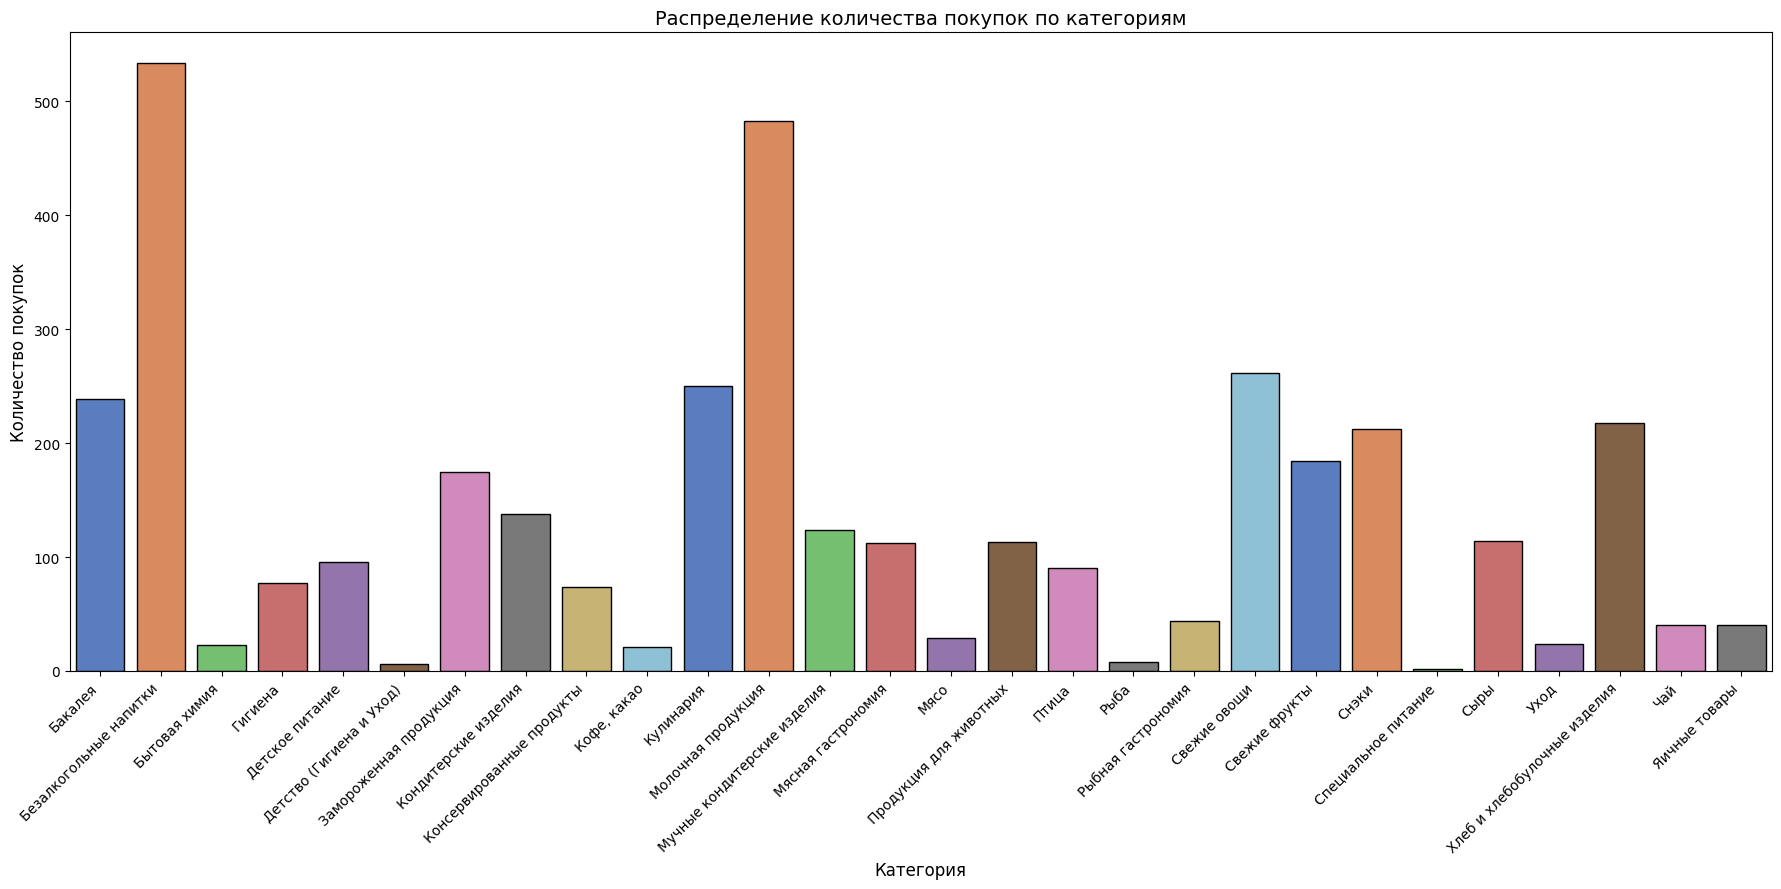

In [332]:
orders_n_products = orders_df.merge(products_df, how = 'left', left_on = 'product_id', right_on = 'product_id')
orders_by_category = (orders_n_products.groupby('level1')
                      .agg({'quantity': sum})
                      .reset_index()
                      .rename(columns={'level1': 'Категория', 'quantity': 'Количество покупок'}))

fig, ax = plt.subplots(1, 1, figsize = (18, 9))
sns.barplot(data = orders_by_category, x = 'Категория', y = 'Количество покупок', hue = 'Категория', ax = ax, palette = 'muted', edgecolor = 'black')

ax.set_title('Распределение количества покупок по категориям', fontsize = 14)
ax.set_xlabel('Категория', fontsize=12)
ax.set_ylabel('Количество покупок', fontsize=12)
ax.set_xticks(range(len(orders_by_category)))
ax.set_xticklabels(orders_by_category['Категория'], rotation=45, ha='right', fontsize=10)


fig.tight_layout()
orders_by_category.to_excel(os.path.join(OUTPUT_FOLDER, 'Продажи по категориям.xlsx'), index = False)
fig.savefig(os.path.join(OUTPUT_FOLDER, 'Столбчатая диаграмма продаж по категориям товаров.pdf'), pad_inches = 0.1)

plt.show()

# Распределение продаж по подкатегориям

In [333]:
categories_n_subcategories_sales = (orders_n_products.groupby(['level1', 'level2'])
                                    .agg({'quantity': sum})
                                    .reset_index()
                                    .rename(columns = {'level1': 'category', 'level2': 'subcategory', 'quantity': 'quantity_of_items'})
                                    .sort_values(by = ['category', 'subcategory', 'quantity_of_items'], ascending = [True, True, False]))

categories_n_subcategories_sales.to_excel(os.path.join(OUTPUT_FOLDER, 'Продажи по категориям и подкатегориям.xlsx'), index = False)

# Найти средний чек в заданную дату

In [329]:
time_mask = orders_n_products['accepted_at'].dt.date == pd.Timestamp('2022-01-13').date()

target_day = orders_n_products.loc[time_mask]
target_day['sales_per_item'] = target_day['price'] * target_day['quantity']
average_order_value = round(target_day['sales_per_item'].to_numpy().sum() / target_day['order_id'].nunique(), 2)

print(f'Средний чек: {average_order_value} руб.')

Средний чек: 915.64 руб.


# Доля промо в заданной категории

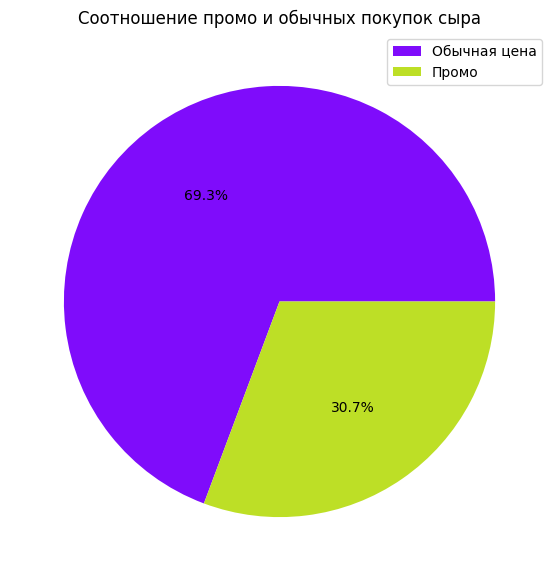

In [277]:
cheese_mask = orders_n_products['level1'] == 'Сыры'
cheeses_orders = orders_n_products.loc[cheese_mask]
cheeses_orders['order_type'] = np.where(cheeses_orders['regular_price'] != cheeses_orders['price'], 'Промо', 'Обычная цена')
cheeses_orders = cheeses_orders.groupby('order_type').agg({'quantity': sum}).reset_index()

fig, ax = plt.subplots(1, 1, figsize = (14, 7))
ax.pie(x = cheeses_orders['quantity'], autopct='%1.1f%%', colors = ["#7F0CFB", "#BDDF26"])
ax.set_title('Соотношение промо и обычных покупок сыра')
ax.legend(labels=cheeses_orders['order_type'])

fig.savefig(os.path.join(OUTPUT_FOLDER, 'Соотношение промо и обычных покупок сыра.pdf'))
plt.show()

# Посчитать маржу по категориям

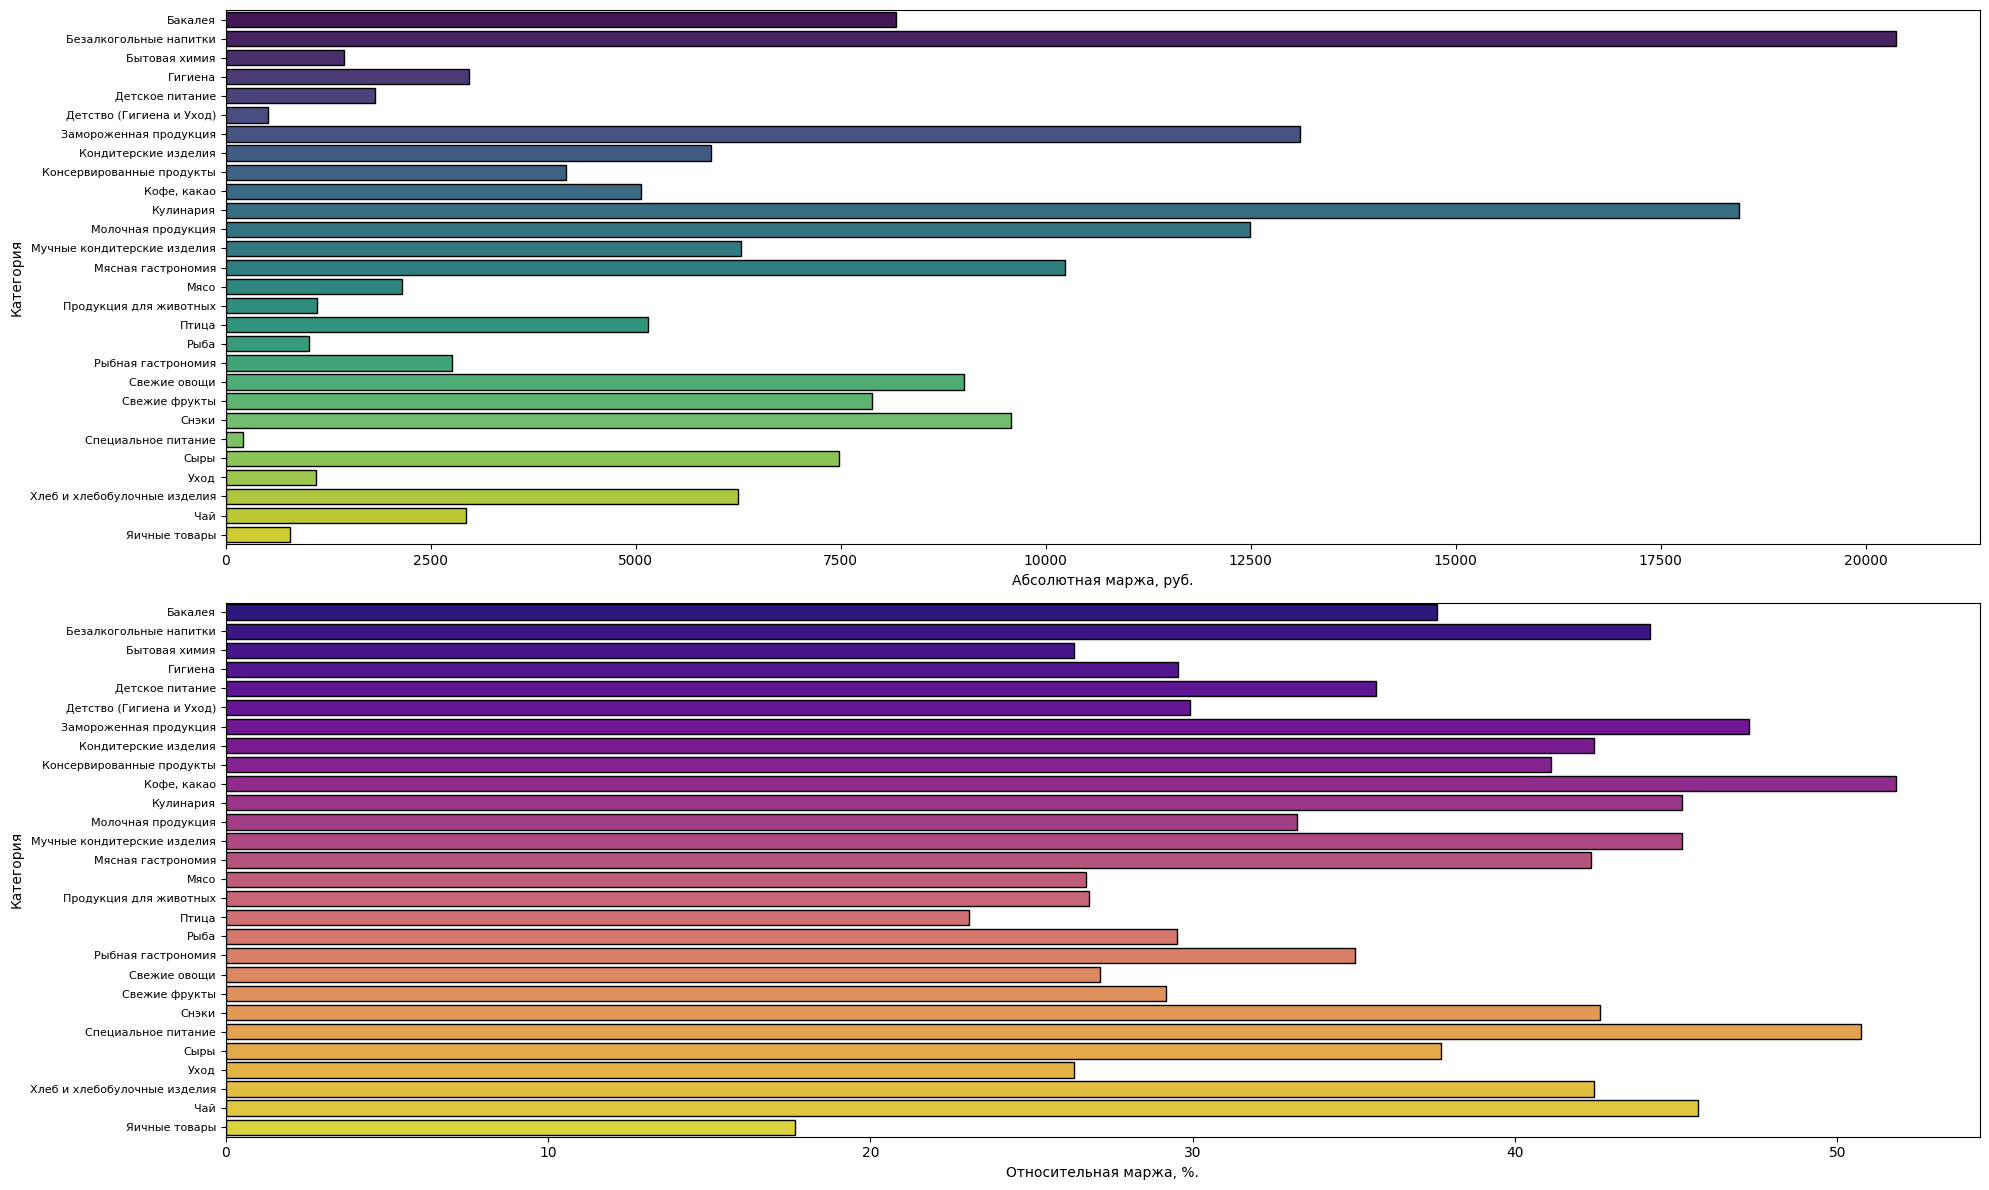

In [331]:
orders_n_products['sales_per_item'] = orders_n_products['price'] * orders_n_products['quantity']
orders_n_products['cost_per_item'] = orders_n_products['cost_price'] * orders_n_products['quantity']

margin = orders_n_products.groupby('level1').agg({'sales_per_item': sum, 'cost_per_item': sum}).reset_index().rename(columns = {'level1': 'category'})
margin['abs_margin'] = margin['sales_per_item'] - margin['cost_per_item']
margin['rel_margin'] = ((margin['sales_per_item'] - margin['cost_per_item']) / margin['sales_per_item']).apply(lambda x: round(x * 100, 2))
margin = margin[['category', 'abs_margin', 'rel_margin']]

fig, ax = plt.subplots(2, 1, figsize = (20, 12))

sns.barplot(data = margin, y = 'category', x = 'abs_margin', edgecolor = 'black', palette= 'viridis', hue = 'category', ax = ax[0])
ax[0].set_xlabel('Абсолютная маржа, руб.', fontsize = 10)
ax[0].set_ylabel('Категория', fontsize = 10)
ax[0].tick_params(axis='y', labelsize=8)

sns.barplot(data = margin, y = 'category', x = 'rel_margin', edgecolor = 'black', palette = 'plasma', hue = 'category', ax = ax[1])
ax[1].set_xlabel('Относительная маржа, %.', fontsize = 10)
ax[1].set_ylabel('Категория', fontsize = 10)
ax[1].tick_params(axis='y', labelsize=8)

plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FOLDER, 'Абсолютная и относительная маржа в процентах.pdf'))


# ABC анализ


order